## Supplementary Figure - Marginal Emissions
Siobhan Powell, 2021.

In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import pickle

In [3]:
from simple_dispatch import bidStack
import matplotlib
import scipy
from future_grid import FutureDemand

In [4]:
unit_drops = pd.read_csv('IntermediateOutputs/scheduled_retirements_2019.csv', index_col=0)
additions_df = pd.read_csv('IntermediateOutputs/generator_additions.csv', index_col=0)
import copy
def drop_add_generators(future_year, gd_short_init, unit_drops=None, additions_df=None, drop=True, add=True):
    
    gd_short_final = copy.deepcopy(gd_short_init)
    if add:
        added_units = additions_df[additions_df['Year']<future_year]['orispl_unit'].values
        for i, val in enumerate(added_units):
            idx = len(gd_short_final.df)
            loc1 = gd_short_final.df[gd_short_final.df['orispl_unit']==val].index
            gd_short_final.df = pd.concat((gd_short_final.df, gd_short_final.df.loc[loc1]), ignore_index=True)
            gd_short_final.df.loc[idx, 'orispl_unit'] = 'added_'+str(i)
        
    if drop:
        dropped_units = unit_drops[unit_drops['retirement_year']<future_year]['orispl_unit'].values
        gd_short_final.df = gd_short_final.df[~gd_short_final.df['orispl_unit'].isin(dropped_units)].copy(deep=True).reset_index(drop=True)
    
    return gd_short_final

In [5]:
year = 2030; solar = 2.5; wind = 2.5; run_year=2019
gd_short = pickle.load(open('IntermediateOutputs/generator_data_short_%s_%s.obj'%('WECC', str(run_year)), 'rb'))
gd_short_copy = drop_add_generators(year, gd_short, drop=True, unit_drops=unit_drops, add=True, additions_df=additions_df)

# Plotting

In [6]:
def set_up_generator(year=2030, fuel=1.0, gd_short_copy=None):
    
    if gd_short_copy is not None:
        return gd_short_copy
    else:
        if year != 2019:
            gd_short_copy = drop_add_generators(year, gd_short, drop=True, unit_drops=unit_drops, add=True, additions_df=additions_df)
        else:
            gd_short_copy = copy.deepcopy(gd_short)
    
    return gd_short_copy

def set_up_scenario(year=2030, solar=2.5, wind=2.5, fuel=1.0, ev_pen=1.0, 
                    ev_scenario='BaseCase_NoL1', ev_timers='', ev_workplace_control='', 
                    ev_workplace_bool=False, evs_bool=True, ev_scenario_date='20210630', gd_short_copy=None):
    
    gd_short_copy = set_up_generator(year=year, fuel=fuel, gd_short_copy=gd_short_copy)
    future = FutureDemand(gd_short_copy, year=year)
    if year != 2019:
        future.electrification(scale_vs_given=True)
    future.solar_multiplier[year] = solar
    future.wind_multiplier[year] = wind
    future.solar()
    future.wind()
    
    if evs_bool:
        if ev_workplace_bool:
            future.evs(pen_level=ev_pen, scenario_name=ev_scenario, timers_extra_info=ev_timers, wp_control=ev_workplace_control, scenario_date=ev_scenario_date)
        else:
            future.evs(pen_level=ev_pen, scenario_name=ev_scenario, timers_extra_info=ev_timers, scenario_date=ev_scenario_date)
    
    future.update_total()
    
    return gd_short_copy, future

In [23]:
solar=2.5
wind=2.5
fuel=1
ev_scenario='BusinessAsUsual'
ev_timers=''
penlevel=1.0
ev_scenario_date='20211119'
gd_short_copy, future = set_up_scenario(year=2030, solar=solar, wind=wind, fuel=fuel, ev_scenario=ev_scenario, 
                                                                                ev_timers=ev_timers, ev_pen=penlevel, ev_workplace_control='minpeak', ev_workplace_bool=True, evs_bool=True, 
                                                                                gd_short_copy=None, ev_scenario_date=ev_scenario_date)
future.demand['demand'] = future.demand['demand'].clip(0, 1e10)
# timer_names = {'':'Timers9pm', '_midnighttimers':'Timers12am', '_NoTimers':'TimersNone'}
save_str = 'Results/Fuel1_Solar25_Wind25/fuel'+str(fuel)+'_solar'+str(solar)+'_wind'+str(wind)+'_'+ev_scenario+'_'+'TimersMixed'+'_WPcontrol_minpeak'+'_penlevel'+str(penlevel)+'_storagebefore'


In [24]:
storage_before = pd.read_csv(save_str+'_storagebeforedf_'+'20211119'+'.csv', index_col=0)
dpdf = pd.read_csv(save_str+'_dpdf_'+'20211119'+'.csv')
test_dpdf = copy.deepcopy(dpdf)

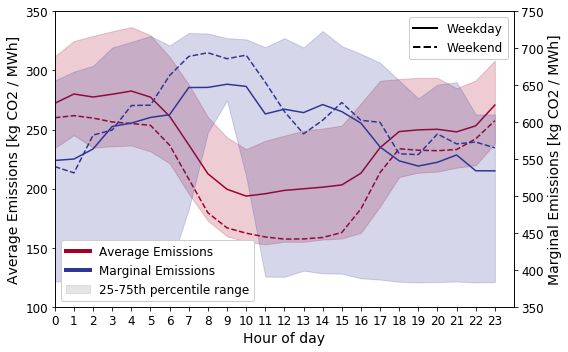

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax2 = ax.twinx()

labels1 = ['Weekday', 'Weekend']
lines = ['-', '--', ':', '-.']
for i, weekdays in enumerate([[0, 1, 2, 3, 4], [5, 6]]):
    subset = test_dpdf[pd.to_datetime(test_dpdf['datetime']).dt.weekday.isin(weekdays)]
    ax.plot(np.reshape(subset['co2_tot'].values / subset['total_incl_noncombustion'].values, (-1, 24)).mean(axis=0), linestyle=lines[i], color='#a50026', label=labels1[i])
    ax2.plot(np.reshape(subset['co2_marg'].values, (-1, 24)).mean(axis=0), linestyle=lines[i], color='#313695', label=labels1[i])
    if i == 0:
        ax.fill_between(np.arange(0, 24), np.percentile(np.reshape(subset['co2_tot'].values / subset['total_incl_noncombustion'].values, (-1, 24)), 25, axis=0), np.percentile(np.reshape(subset['co2_tot'].values / subset['total_incl_noncombustion'].values, (-1, 24)), 75, axis=0), alpha=0.2, color='#a50026')
        ax2.fill_between(np.arange(0, 24), np.percentile(np.reshape(subset['co2_marg'].values, (-1, 24)), 25, axis=0), np.percentile(np.reshape(subset['co2_marg'].values, (-1, 24)), 75, axis=0), alpha=0.2, color='#313695')


legend_elements1 = [Line2D([0], [0], color='#a50026', lw=4, label='Average Emissions'),
                   Line2D([0], [0], color='#313695', lw=4, label='Marginal Emissions'),
                   Patch(facecolor='grey', edgecolor='grey', alpha=0.2, label='25-75th percentile range')]

legend_elements2 = [Line2D([0], [0], color='k', linestyle=lines[0], lw=2, label='Weekday'),
                   Line2D([0], [0], color='k', linestyle=lines[1], lw=2, label='Weekend')]
ax2.legend(handles=legend_elements1, loc='lower left', fontsize=12, framealpha=1.0, fancybox=True)
ax.legend(handles=legend_elements2, loc='upper right', fontsize=12, framealpha=1.0, fancybox=True)

    
ax.set_ylabel('Average Emissions [kg CO2 / MWh]', fontsize=14)
ax2.set_ylabel('Marginal Emissions [kg CO2 / MWh]', fontsize=14)
ax.set_yticks([100, 150, 200, 250, 300, 350])
ax.set_yticklabels([100, 150, 200, 250, 300, 350], fontsize=12)
ax2.set_yticks([350, 400, 450, 500, 550, 600, 650, 700, 750])
ax2.set_yticklabels([350, 400, 450, 500, 550, 600, 650, 700, 750], fontsize=12)
ax.set_xlim([0, 24]); ax.set_xticks(np.arange(0, 24, 1)); ax.set_xticklabels(np.arange(0, 24, 1), fontsize=12)
ax2.set_xlim([0, 24]); ax2.set_xticks(np.arange(0, 24, 1))
ax.set_xlabel('Hour of day', fontsize=14)
plt.tight_layout()
plt.savefig('SupplementPlotting/Plots/supfig3.pdf', bbox_inches='tight')
plt.show()
